## Look at the Big Picture

- California census data는 각 block group(600~3000명)에서의 population(인구), median income(중위 소득), median houising price(중위 주택 가격) 등을 가지고 있음

- 모형은 이 자료를 통해 어떤 구역이든지 그 중위 주택 가격을 예측할 수 있어야 함

### 1. Frame the Problem

1. supervised vs unsupervised vs Reinforcement Learning

2. classification vs regression vs something else

3. batch learning vs online learning

#### 1) supervised 2) multivariate regression 3)  batch learning

### 2. Select a Performance Measure

RMSE: A typical performance measure for regression
problems

MAE: outlier(이상치)가 많을 때 사용

### 3. Check the Assumptions

ex) regression task를 선택했는데 가격변수가 범주형 변수라면? 

## Get the Data

### 1. Download the Data

In [ ]:
import os
import numpy as np

np.random.seed(42)   # 일관된 출력을 위해 유사난수 초기화

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
plt.rcParams['axes.labelsize'] = 14   # rcParams을 이용하여 차트 그림(figure)의 기본 설정을 지정
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sn.set()

matplotlib.rc('font', family='NanumBarunGothic')   # 한글출력
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
import pandas as pd

housing = pd.read_csv('C:/Users/Park JuYoung/Desktop/머신러닝/Week3/housing.csv')

### 2. Take a Quick Look at the Data Structure

In [ ]:
housing.head()

# 각 행은 한 district를 나타냄
# 10개의 속성(열)을 가짐

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

# 총 20640개의 instances를 가지며 이는 머신러닝에서 꽤 작은 크기임
# total_bedroom을 보면 207개의 district에서 결측치가 있음을 확인할 수 있음
# ocean_proximity만 object(text): 범주형 자료이고 나머지는 전부 numerical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing["ocean_proximity"].value_counts()   # value_counts(): 무슨 범주가 존재하고 얼마나 많은 districts가 각 범주에 속하는지 확인

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
display(housing.describe())   # 수치형 자료의 summary

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


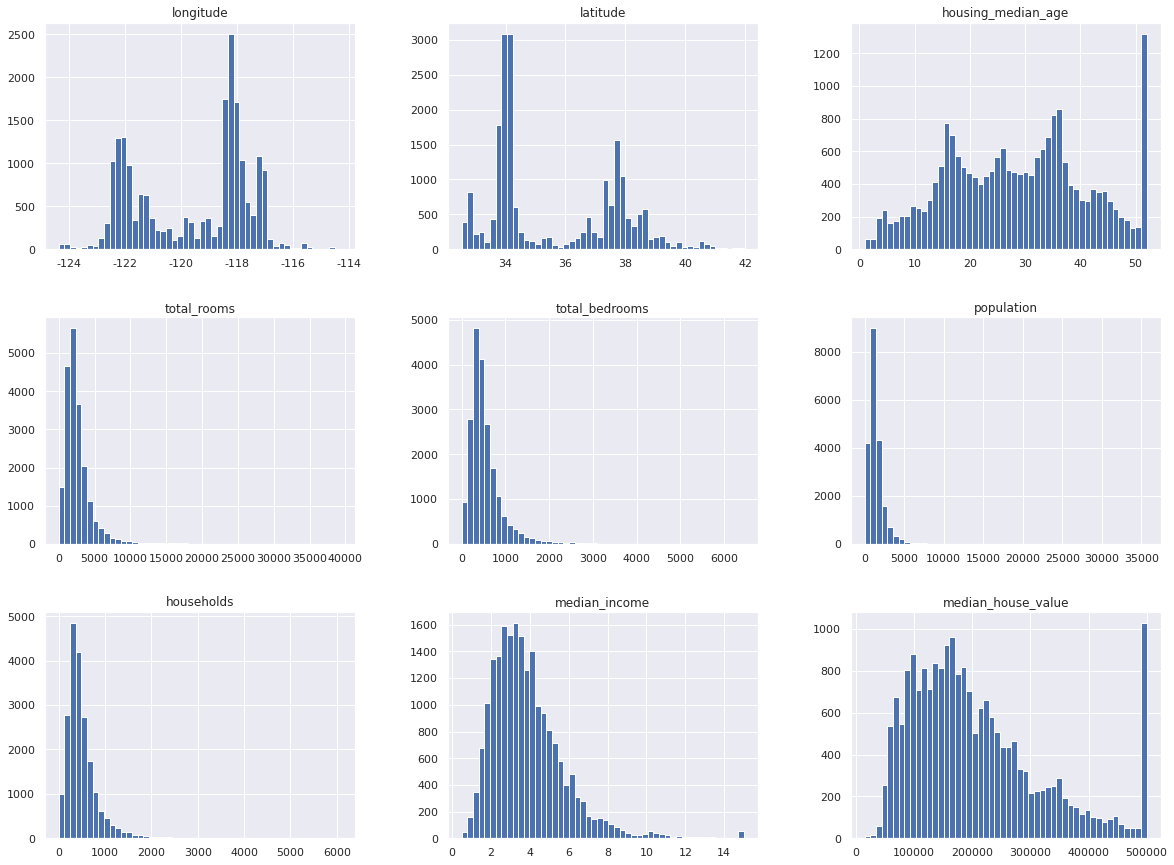

In [ ]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

##### 히스토그램을 통해 알 수 있는 점들

1. 중위소득은 US Dollors로 표현된 것처럼 보이지 않음 (자료가 scale 되었음) cf) x축과 y축을 잘 보자!

2. 주택 중간 연령과 중간 주택 가격 모두 상한선 있음. 중간 주택 가격의 경우 우리의 target attribute이기 때문에 문제가 될 수 있음. client 팀과 함께 확인해 본 결과 상한선 밑의 정확한 예측치가 필요하다면 다음 두가지 옵션이 있음

a) 상한선이된 district의 적절한 레이블들을 수집

b) 상한선이된 district를 training/test set에서 모두 제거

3. 이 속성(열)들은 모두 다른 척도를 가지고 있음 (feature scailing 필요)

4. 많은 히스토그램의 꼬리가 두터움: 중위수의 왼쪽보다 오른쪽으로 훨씬 치우쳐 있음. 이는 ML 알고리즘이 패턴을 찾기 어렵게 만듦. 그러므로 bell-shaped 분포가 되도록 변형시켜야 함

### 3. Create a Test Set

#### 1) np.random.permutaion을 이용해 Train/Test set 나누기

dataset을 업데이트할 경우 solutions will break

In [ ]:
np.random.seed(42)
def split_train_test(data, test_ratio):   # 자료와 test_ratio를 넣어 train data와 test data를 구분하는 함수 생성
    shuffled_indices = np.random.permutation(len(data))   # np.random.permutaion을 이용
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = split_train_test(housing, 0.2)   # 20%만큼을 test data로 분류
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [ ]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


#### 2) hashlib을 이용해 Train/Test set 나누기

np.permutaion()의 단점을 보완하는 방법

In [ ]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio   # digest(): 요약
# hash의 마지막 byte 값(identifier)이 51(256의 test ratio(20%)) 이하인 instances를 test set에 할당        
# 여러번 학습시켜도 test set을 지속적으로 사용 가능

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
housing_with_id = housing.reset_index() # adds an `index` column
# housing data set에는 identifier column이 없기 때문에 index를 추가해 사용

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print(len(train_set),"train +",len(test_set),"test")

16362 train + 4278 test


In [ ]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY
20,20,-122.27,37.85,40.0,751.0,184.0,409.0,166.0,1.3578,147500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


In [ ]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
# latitude와 longtitude(잘 변하지 않는 속성)를 사용해 고유의 identifier를 만들어 사용

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
print(len(train_set),"train +",len(test_set),"test")

16267 train + 4373 test


In [ ]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


#### 3) sklearn의 train_test_split을 이용한 Train/Test set 나누기

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


#### 4) sklearn의 StratifiedShuffleSplit을 이용한 Train/Test set 나누기

Train/Test set이 모수에 대한 대표성을 가지고 편향이 없도록 표본추출될 수 있도록 계층마다 샘플링을 하는 계층적 샘플링(stratified sampling)을 사용

In [ ]:
housing['median_income']

0        8.3252
1        8.3014
2        7.2574
3        5.6431
4        3.8462
          ...  
20635    1.5603
20636    2.5568
20637    1.7000
20638    1.8672
20639    2.3886
Name: median_income, Length: 20640, dtype: float64

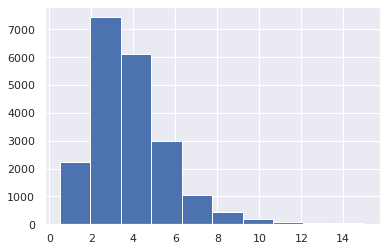

In [ ]:
housing['median_income'].hist();

In [ ]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)   # 소득 범주의 수를 제한하기 위해 1.5로 나눠줌
                                                                  # 이산형 범주를 갖기 위해 올림 처리 해줌
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)   # 범주를 총 5개로 병합

In [ ]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

<AxesSubplot:>

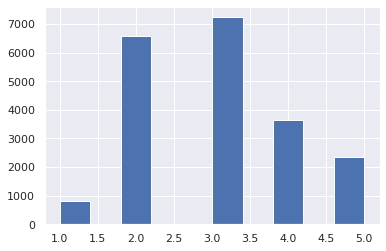

In [ ]:
housing["income_cat"].hist()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit   # 층화표본추출 시행

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)   # train과 test로 한 번만 분할하기 때문에 n_splits=1
for train_index, test_index in split.split(housing, housing['income_cat']):   # income_cat의 비율을 반영해 분할
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [ ]:
display(housing['income_cat'].value_counts() / len(housing))   # full data에서의 수입 카테고리 비중
print('='*20)
display(strat_test_set['income_cat'].value_counts() / len(strat_test_set))   # 계층별로 나눈 data(stratified sampling)에서의 수입 카테고리 비중

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [ ]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [ ]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114583,0.109496,-4.318374,0.127011


random과 stratified 표본 추출을 비교해봤을 때 stratified 방법이 full dataset과 거의 일치하는 반면 random 방법은 상당히 skewed함을 알 수 있다.

In [ ]:
# 분석에 필요없는 'income_cat' Column 삭제
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize the Data to Gain Insights

1. training set만을 탐구

2. training set이 너무 크다면 exploration set을 표본추출

In [ ]:
# Train set에 대해서만 진행
housing = strat_train_set.copy()

### 1) Visualizing Geographical Data

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


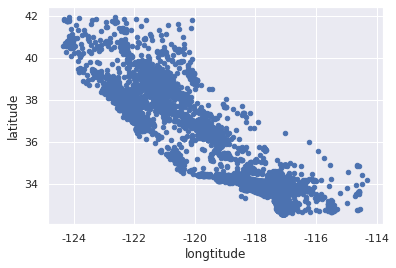

In [ ]:
ax = housing.plot(kind='scatter', x='longitude', y='latitude')
ax.set(xlabel='longtitude', ylabel='latitude');

위도와 경도를 시각화해 캘리포니아 주의 모양을 나타낼 수 있지만 어떤 특정한 패턴을 찾기 어려움

- 투명도를 조절해 data의 밀도를 파악해보자

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[Text(0.5, 0, 'longtitude'), Text(0, 0.5, 'latitude')]

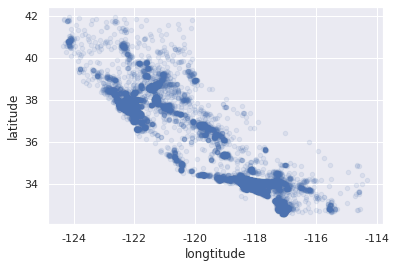

In [ ]:
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
ax.set(xlabel='longtitude', ylabel='latitude')

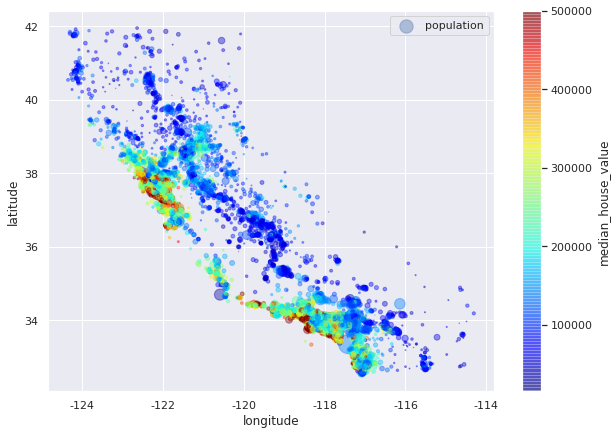

In [ ]:
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),   # 동그라미 크기=인구
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,   # 색깔=가격(파랑-낮은가격 ~ 빨강-높은가격, color map 사용
    sharex=False)
ax.set(xlabel='longitude', ylabel='latitude')
plt.legend()

- 주택 가격은 지역에 관계되어 나타남을 알 수 있음 (ex. 바다에 가까우면 주택 가격이 높음)

- clustering 알고리즘을 사용해 main clusters를 찾는 것이 유용할 수 있음

- cluster의 centers와 가까운 정도를 측정하는 새로운 특성 변수를 추가해야 함

- 비록 북부 캘리포니아는 바다에 가까워도 주택 가격이 높지 않지만 ocean proximity 속성도 유용할 것

### 2) Looking for Correlations

- 자료가 그렇게 크지 않기 때문에 모든 속성 간의 상관계수(r)를 쉽게 구할 수 있음

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
# 중간 주택 가격과의 상관계수 확인

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


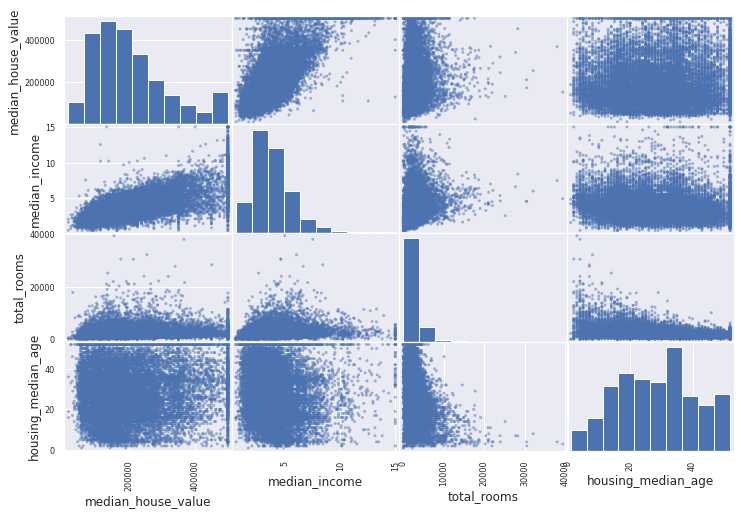

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]   # 특정 4 변수만을 골라 서로간의 상관계수를 pandas를 활용해 확인(4X4). 전부 확인하기에는 변수가 너무 많음
scatter_matrix(housing[attributes], figsize=(12, 8));

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


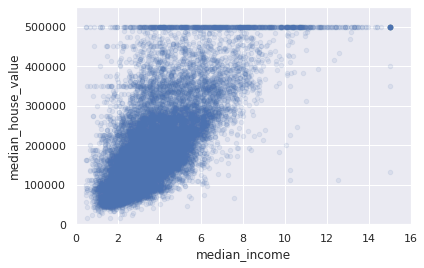

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)   # 가장 유력한 변수인 중위소득의 산점도를 확인
plt.axis([0, 16, 0, 550000]);

1. 상관관계가 매우 강함: 많이 퍼져 있지 않고 우상향한 그림

2. 우리가 초기에 발견한 price cap이 500,000 달러 부근에서 수평선으로 나타남

3. 450,000 달러와 350,000 달러, 280,000 달러 부근에도 희미하지만 수평선이 나타남

### 3) Experimenting with Attribute Combinations

독립적으로는 유용하지 않은 변수들을 각각의 조합을 통해 쓰임새 있는 새로운 속성을 생성

In [ ]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

- bedrooms_per_room 변수가 total_bedrooms 변수보다 높은 상관관계를 보여줌: 전체 방에서 침실의 비중이 적으면 당연히 그 집은 비싼 경향을 보임 (음의 상관관계)

- rooms_per_household 변수도 total_rooms 변수보다 더 informative: 집이 클수록 비싼 것은 당연함

## Prepare the Data for Machine Learning Algorithms

In [ ]:
housing = strat_train_set.drop('median_house_value', axis=1)   # predictors
housing_labels = strat_train_set['median_house_value'].copy()   # labels

In [ ]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [ ]:
housing_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
           ...   
6563     240200.0
12053    113000.0
13908     97800.0
11159    225900.0
15775    500001.0
Name: median_house_value, Length: 16512, dtype: float64

### 1) Data Cleaning

- 결측값이 있으면 대부분의 머신러닝 알고리즘은 작동하지 않음

- 이를 관리하기 위해 세 가지 방법이 있음

1. 관련 구역을 제거: dropna()

2. 전체 변수를 제거: drop()

3. 어떤 값으로 채움: fillna()  ex) 0, 평균, 중위수 등등

In [ ]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows
# 결측값 있는 행 불러들이기

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [ ]:
# 방법1: null값 삭제 -> dropna()
sample_incomplete_rows.dropna(subset=['total_bedrooms'])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [ ]:
# 방법2: 전체 특성(total_bedrooms) 삭제 -> drop()
sample_incomplete_rows.drop('total_bedrooms', axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [ ]:
median = housing['total_bedrooms'].median()
sample_incomplete_rows['total_bedrooms'].fillna(median, inplace=True)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


In [ ]:
from sklearn.impute import SimpleImputer  # Scikit-Learn은 결측값을 손쉽게 다룰 imputer를 제공

housing_num = housing.drop('ocean_proximity', axis=1)   # numerical 변수만을 남김(median 측정 위해)

imputer = SimpleImputer(strategy='median')   # imputer 생성
imputer.fit(housing_num)   # training data에 imputer를 적용

SimpleImputer(strategy='median')

In [ ]:
print('imputer.statistics_ :', imputer.statistics_)
print('housing_num.median().values :', housing_num.median().values)

imputer.statistics_ : [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
housing_num.median().values : [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


- 각 특성변수의 중위수 계산해 statistics_라는 변수에 저장

- total_bedrooms 변수에만 결측값이 있기는 하지만, 시스템 가동된 후의 새로운 자료에서 결측값이 없을거라고 확신할 수 없기 때문에 모든 numerical 변수에 대해 imputer를 사용하는 것이 안전함

In [ ]:
X = imputer.transform(housing_num)   # imputer의 .transform()을 이용해 Training set의 누락된 값을 중앙값으로 바꿔줌

# NumPy의 array이므로 다시 pandas.DataFrame으로 변환해준다.
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index.values)

# Null값이 median 값으로 잘 채워졌는지 확인
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


### 2) Handling Text and Categorical Attributes

- 범주형 변수인 ocean_proximity를 숫자로 변환

In [ ]:
from sklearn.preprocessing import LabelEncoder   # LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [ ]:
print(encoder.classes_)   # 1H OCEAN:0 ~ NEAR OCEAN:4

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


- LabelEncoder를 사용할 경우 가까운 값이 멀리 떨어진 값보다 비슷하다고 가정. 하지만 실제 우리 데이터에서는 0과 1보다 0과 4가 더 가까움.

- 이러한 문제를 해결하기 위해 binary attribute per category를 생성: one-hot encoding

- One-hot Encoding: 해당하는 경우에 1을, 아닌 경우 0을 할당해 one-hot vector를 생성

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
# fit_transform()함수는 2D array를 받아줘야 하는데 housing_cat_encoded가 1D array이기 때문에 reshape함수로 재조정해줌
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
housing_cat_1hot.toarray()   # one-hot encoding은 메모리를 많이 사용하기 때문에 이를 방지하고자 1 값만 저장. array로 사용하기 위해서는 .toarray()메소드를 사용

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
# [PR #9151](https://github.com/scikit-learn/scikit-learn/pull/9151)에서 가져온 CategoricalEncoder 클래스의 정의.
# 이 클래스는 사이킷런 0.20에 포함될 예정입니다.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [ ]:
cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
from sklearn.preprocessing import LabelBinarizer   # text 카테고리를 integer 카테고리로 바꾸고 이를 one-hot vectors로 바꾸는 것을 한번에 하기 위해 LabelBinarizer 사용
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

### 3) Custom Transformers

- Scikit-Learn은 다양한 기능을 제공하지만 경우에 따라서는 scikit-Learn에서 다루지 않는 기능이 필요할 수도 있음

- 세 가지 메소드: fit(), transform(), fit_transform() 를 사용

- https://www.inflearn.com/questions/19038

- fit_transform(): TransformerMixin을 base class로 추가해 구함

- get_params(), set_params(): BaseEstimator를 base class로 추가해 구하며 이는 초모수를 조정하는데 유용하게 사용됨

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs, 
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


### 4) Feature Scaling

- 몇 가지 경우를 제외하고 대부분의 머신러닝 알고리즘은 수치형 변수가 서로 다른 척도를 가지고 있을 때 잘 수행하지 못함.

ex) #rooms(6 ~ 39,320), 중위소득(0 ~ 15)

- 같은 척도를 갖게 하기 위해 두가지 방법이 있음: min-max scailing, standardization

1. min-max scailing(normalizaion): 0부터 1의 값으로 재조정됨(가장 작은 값을 빼준 후 range 값으로 나눠 줌). Scikit-Learn의 MinMaxScaler로 사용할 수 있으며 feature_range를 사용해 0~1의 범위를 조정할 수도 있음

2. Standardization: 평균이 0을 갖게 끔 하는 표준화 작업. 특정 범위 안에 들어오는 것이 아니기 때문에 문제가 될 수도 있지만 이상치의 영향을 덜 받는 장점이 있음. Scikit-Learn의 StandardScaler로 사용

### 5) Transformation Pipelines

- Scikit-Learn의 Pipeline class는 데이터 전처리와 관련된 일련의 과정을 순서대로 진행하게 도와줌

https://rk1993.tistory.com/entry/Python-sklearnpipeline-%ED%8C%8C%EC%9D%B4%ED%94%84%EB%9D%BC%EC%9D%B8Pipeline%EC%9D%B4%EB%9E%80

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),   # StandardScaler: transformer 함수
])

housing_num_tr = num_pipeline.fit_transform(housing_num)  # fit()+transform()

In [ ]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

- Pandas DataFrame을 직접 pipeline에 넣어 돌리면 좋을 것

- Scikit-Learn에서는 Pandas의 DataFrames를 다룰 수 있는 기능이 없기 때문에 직접 custom transformer를 작성해 Numpy array로 바꿔주어야 한다.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [ ]:
num_attribs = housing_num.columns.tolist()
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),   # numerical values
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),   # rooms_per_household, population_per_household 추가
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
])

In [ ]:
housing_cat_tr = cat_pipeline.fit_transform(housing)
housing_cat_tr

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
from sklearn.pipeline import FeatureUnion   #  두개의 pipeline을 하나로 합침

full_pipeline = FeatureUnion(transformer_list=[
        ('num_pipeline', num_pipeline),
        ('cat_pipeline', cat_pipeline),
])

In [ ]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
print('housing_prepared.shape :', housing_prepared.shape)   # 10 + r_p_h + p_p_h + encoding(4) =16

housing_prepared.shape : (16512, 16)


## Select and Train a Model

### 1) Training and Evaluating on the Training Set

In [ ]:
from sklearn.linear_model import LinearRegression   # LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [ ]:
# 훈련 샘플 몇 개를 사용해 전체 파이프라인을 적용해 보기
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [ ]:
from sklearn.metrics import mean_squared_error   # RMSE 계산

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print('RMSE :', lin_rmse)

RMSE : 68628.19819848923


- 오차가 만족스러울만큼 작지 않음: underfitting
- 특성변수가 충분한 정보를 제공하지 못하거나 모형이 충분히 강력하지 않음
- 이러한 underfitting을 줄이기 위해서 더 나은 모형을 선택하거나 더 나은 특성변수로 알고리즘을 훈련시키거나 모형의 규제를 줄여야 함

In [ ]:
from sklearn.tree import DecisionTreeRegressor   # 복잡한 비선형 관계를 찾기에 강력한 모형

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print('RMSE :', tree_rmse)

RMSE : 0.0


- error가 0: 모형이 overfit 됐을 가능성이 높음

### 2) Better Evaluation Using Cross-Validation

- K-fold cross-validation: training set을 랜덤하게 10개의 구역(fold)으로 나누고 훈련 시킨 후 Decision Tree 모형을 10번 평가

- 평가를 위한 fold 1개를 매번 선택한 후 나머지 9개의 fold에 대해 훈련을 진행

- 결과는 10개의 평가 점수가 포함된 array로 나타남

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# DecisionTree
display_scores(tree_rmse_scores)

Scores: [69327.01708558 65486.39211857 71358.25563341 69091.37509104
 70570.20267046 75529.94622521 69895.20650652 70660.14247357
 75843.74719231 68905.17669382]
Mean: 70666.74616904806
Standard deviation: 2928.322738055112


- 전에 봤던 것 만큼 좋아보이지 않음 (약 70666)

- Linear Regression 모형보다 더 안좋음

- cross-validaion은 모형의 수행능력 뿐만 아니라 얼마나 이 추정치가 정확한지도 측정 (표준편차)

In [ ]:
# Linear Regression
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798344


##### RandomForestRegressor

- Random Forests: 특성 변수의 임의의 부분집합에 대해 Decision Trees를 훈련시킴으로써 작동

- 그것들의 예측치의 평균을 냄

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print('RMSE :', forest_rmse)

RMSE : 18603.515021376355


In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


- 훨씬 나은 결과

- 하지만 training set의 score가 cross-validation의 score보다 훨씬 낮음: 여전히 overfitting

## Fine-Tune Your Model

### 1) Grid Search

- 상대적으로 조합이 거의 없을 때 사용  

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 하이퍼파라미터 12(=3×4)개의 조합
    # n_estimators는 생성할 트리 개수
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# 다섯 폴드에서 훈련하면 총 (12+6)*5=90번의 훈련
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', 
                           return_train_score=True, n_jobs=-1)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

RandomForestRegressor를 위한 초모수 값의 가장 최고의 조합을 찾아내는 코딩

In [ ]:
grid_search.best_params_   # best combinatio of parameters

{'max_features': 8, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_   # best estimator

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [ ]:
cvres = grid_search.cv_results_   # evaluation scores
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

### 2) Randomized Search

- 초모수 search space가 클 때 RandomizedSearchCV로 대신해서 사용

- GridSearchCV와 거의 비슷하지만 모든 가능한 조합 대신 주어진 숫자의 랜덤 combinations를 매 반복 마다 각각 랜덤의 초모수 값을 선택하면서 평가

- 이점 1: 반복을 1000번 실시했다면 1000개의 서로 다른 초모수 값을 구할 수 있음

- 이점 2: 반복의 수를 설정함으로써, 초모수 탐색에 할당하고 싶은 예산을 마음대로 조정할 수 있음

### 3) Ensemble Methods

- 가장 perform을 잘하는 모형을 결합해 system을 미세 조정할 수 있음 (Chapter.7)

### 4) Analyze the Best Models and Their Errors

ex) RandomForestRegressor는 정확한 예측치를 만들어내기 위해 각 속성의 상대적인 중요성을 나타냄

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

위의 정보로 덜 유용한 특성변수를 버릴 수 있음

### 5) Evaluate Your System on the Test Set

- test set에서 최종 모형을 평가

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

47730.22690385927